# ML pipeline on dataset generated after deletion of impossible zeros (disguised missing values) from the original dataset

# The pipeline of ML models is as follows:
- Define X (data containing predictor variables) & y (data containing Outcome variable)

- Standardisation of dataset: As in our datasets, all variables are measured at different scales and do not contribute equally to the model fitting and model learned function so may create a bias. Thus, to deal with this potential problem feature-wise standardised (μ=0, σ=1) is usually used prior to model fitting. Here, we have used standard scaler that removes the mean & scaler each feature to unit variance & this is performed in feature-wise in an independent way. Although we mentioned earlier that our datasets have outliers and standard scaler can be influenced by outliers (if they exist in the dataset) since it involves the estimation of the empirical mean and standard deviation of each feature.

- Train-test split: It is a general practice to avoid training and testing on the same data, so before model application we will split data into train & test. The reasons are that the goal of the model is to predict out-of-sample data, and the model could be overly complex leading to overfitting. To avoid the aforementioned problems, there are two precautions-Train/Test Split & Stratified K-Fold Cross-Validation. We will import “train_test_split” for train/test split and “cross_val_score” for stratified k-fold cross-validation. “accuracy_score” is to evaluate the accuracy of the model in the train/test split method.

- Models application & comparison of accuracy scores

- Stratified K fold cross validation of all models & comparison of accuracy score: it is similar  to K-Fold Cross-Validation method that splits the data set into K equal partitions (“folds”, here we have used n=10, so 10 fold), then use 1 fold as the testing set and the union of the other folds as the training set. Then the model is tested for accuracy. The process will follow the above steps K times, using different folds as the testing set each time. The average testing accuracy of the process is the testing accuracy. The only difference is that in stratified k-fold cross-validation, the folds are selected so that the mean response value is approximately equal in all the folds. In the case of a dichotomous classification, this means that each fold contains roughly the same proportions of the two types of class labels (Wikipedia). So here, we noticed that outcome variable had imbalanced classes (diabetic & non-diabetic persons are unequal). So for ensuring that training & test dataset contains equal proportion of outcome variable, we opted for stratified K fold cross validation.

- Recursive features elimination of two top performing models

- Hyperparameter optimisation of top performing model using Gridsearch CV 

- Final accuracy checking after hyperparameter optimisation

# Import necessary libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV

In [4]:
#Loading the modified dataset (dataset that we generated in after deleting missing values in original dataset
diabetes_df_copy = pd.read_csv("diabetes_df_copy.csv")

In [5]:
# Define X and y
X = diabetes_df_copy[diabetes_df_copy.columns[:-1]]
y = diabetes_df_copy.Outcome


# scaling the data

In [6]:
#scaling the data as there is huge difference in magnitude of data in each column
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split of data

In [7]:
# Splitting the dataset into training & test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=diabetes_df_copy.Outcome,random_state=0)


# ML Models

In [8]:
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVC', SVC()))
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))

In [9]:
names = []
scores = []
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
    names.append(name)
tr_split = pd.DataFrame({'Name': names, 'Score': scores})
print(tr_split)

  Name     Score
0  KNN  0.724490
1  SVC  0.724490
2   LR  0.755102
3   DT  0.693878
4  GNB  0.775510
5   RF  0.765306
6   GB  0.806122


# StratifiedK-Fold Cross-Validation


When we fit aforesaid models a loop on the dataset ,we get the accuracy of the respective model using the “accuracy_score” which is shown below in the table.

Here we see, that GB seems to have highest accuracy followed by GNB and then LR. 
But after stratifiedK fold cross validation, accuracy score of all models changed. We can see from the table, that GB is still best performing model followed by RF and LR.


In [10]:
names = []
scores = []
for name, model in models:
    
    skfold = StratifiedKFold(n_splits=10) 
    score = cross_val_score(model, X_scaled, y, cv=skfold, scoring='accuracy').mean()
    
    names.append(name)
    scores.append(score)
skf_cross_val = pd.DataFrame({'Name': names, 'Score': scores})
print(skf_cross_val)

  Name     Score
0  KNN  0.770385
1  SVC  0.767821
2   LR  0.780385
3   DT  0.713974
4  GNB  0.772692
5   RF  0.790705
6   GB  0.798654


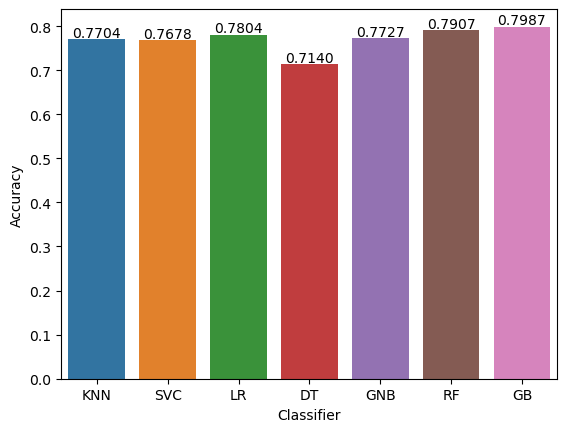

In [11]:
axis = sns.barplot(x = 'Name', y = 'Score', data = skf_cross_val)
axis.set(xlabel='Classifier', ylabel='Accuracy')
for p in axis.patches:
    height = p.get_height()
    axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center") 

plt.show()

At the baseline GB managed to achieve a classification accuracy of 79.87 %. This will be selected as the prime candidate for the next phases.

# Feature Engineering
- We know that all predictors do not equally contribute to the outcome variable so most of the time, there are variables that don’t improve the model. Such cases can be found by further analysis of the features related to the model. So after model selection, Feature Engineering should be considered. Therefore we will be analyzing the selected model which is GB, and how feature importance affects it.

- Scikit Learn provided useful methods by which we can do feature selection and find out the importance of features which affect the model. In the present project, we will be using Recursive Feature Elimination as the feature selection method. RFE works by recursively removing attributes and building a model on those attributes that remain and it employs the model accuracy to identify which attributes (and combination of attributes) contribute the most to predicting the target attribute.

# Gradient boosting classifier- Feature selection
- We found out that GB was the best performing classifier for dataset generated after deletion of impossible zeros from the PID dataset. With the help of rfecv.support_ function we will find out which features are contributing significantly for GB classification algorithm.

/Users/promilasharan/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


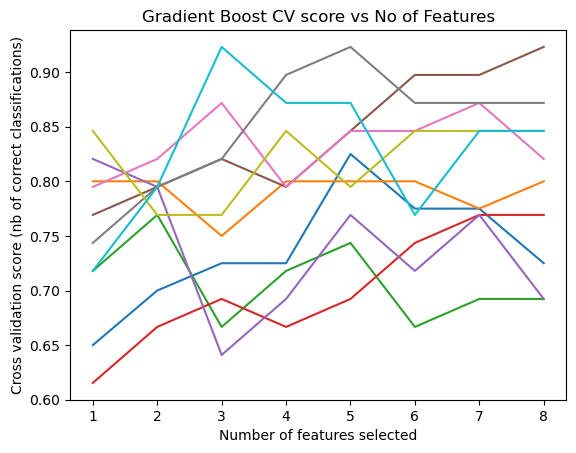

In [13]:
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_selection import RFECV


gb_model = GradientBoostingClassifier()
gb_rfecv = RFECV(estimator=gb_model, step=1, cv=skfold, scoring='accuracy')
gb_rfecv.fit(X_scaled, y)
plt.figure()
plt.title('Gradient Boost CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(gb_rfecv.grid_scores_) + 1), gb_rfecv.grid_scores_)
plt.show()

In [14]:
#We can see that having 5 input features generates the maximum accuracy.
feature_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
feature_importance = list(zip(feature_names, gb_rfecv.support_))
new_features = []
for key,value in enumerate(feature_importance):
    if(value[1]) == True:
        new_features.append(value[0])
        
print(new_features)

['Pregnancies', 'Glucose', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


Here we infer that, following seven features are contributing significantly towards outcome variable in GB model. It seems that blood pressure is recursive feature for the GB model and hence removed.


Now, We can conclude that the given seven features are the most suitable for predicting the outcome class. We can also perform a comparison of the GB model with original features and the RFECV selected features to see if there is an improvement in the accuracy scores.


In [15]:
new_features=['Pregnancies', 'Glucose', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

df_X= pd.DataFrame(X_scaled)
df_X.columns=diabetes_df_copy.columns[:-1]
df_X.head(2)
df_X.shape

(392, 8)

In [16]:
df_X[['Pregnancies', 'Glucose', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]
df_X.isnull().sum()
X_new = df_X[new_features]
X_new.shape

(392, 7)

In [17]:
#The above 7 features are most suitable for the model. We can compare the accuracy before and after feature selection.

initial_score = cross_val_score(gb_model, X_scaled, y, cv=skfold, scoring='accuracy').mean()
print("Initial accuracy : {} ".format(initial_score))
fe_score = cross_val_score(gb_model,X_new , y, cv=skfold, scoring='accuracy').mean()
print("Accuracy after Feature Selection : {} ".format(fe_score))

Initial accuracy : 0.798653846153846 
Accuracy after Feature Selection : 0.8062820512820512 


Here, we see that accuracy of GB classifier was significantly improved (from 79.87% to 80.63%) after removing blood pressure from the dataset.

# Logistic regression - Feature selection
- We can also analyze the second best model we had which is LR classifier, to see if features selection process increases the model accuracy and if it would be better than GB after the process. We will follow the same procedure that we followed for GB. We can see that having 4 input features generates the maximum accuracy.


In [18]:
logreg_model = LogisticRegression()
rfecv = RFECV(estimator=logreg_model, step=1, cv=skfold, scoring='accuracy')
rfecv.fit(X_scaled, y)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=LogisticRegression(), scoring='accuracy')

/Users/promilasharan/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


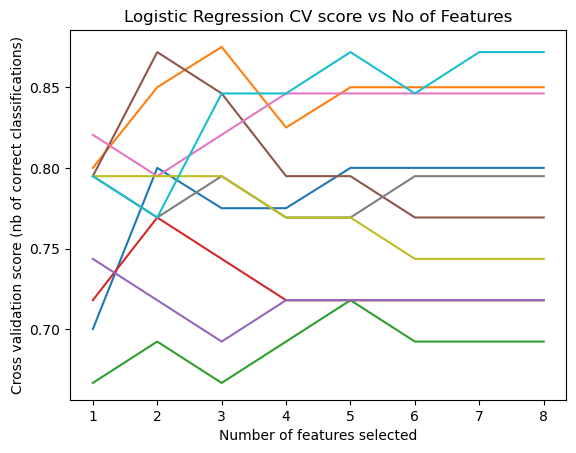

In [19]:
plt.figure()
plt.title('Logistic Regression CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


In [21]:
feature_importance = list(zip(feature_names, rfecv.support_))
new_features = []
for key,value in enumerate(feature_importance):
    if(value[1]) == True:
        new_features.append(value[0])
        
print(new_features)

['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Age']


We can see that having five input features (no. of pregnancies, glucose, BMI, DPF & age) generates the maximum accuracy.


In [22]:
new_features=['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Age']

df_X= pd.DataFrame(X_scaled)
df_X.columns=diabetes_df_copy.columns[:-1]
df_X.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,-0.717427,-1.091046,-0.373655,-0.585110,-0.522842,-0.710421,-1.031876,-0.968299
1,-1.029213,0.466314,-2.456964,0.557421,0.100631,1.426730,5.115111,0.209585


In [23]:
df_X[['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Age']]
df_X.isnull().sum()
X_new = df_X[new_features]

In [24]:
# Calculate accuracy scores

initial_score = cross_val_score(logreg_model, X_scaled, y, cv=skfold, scoring='accuracy').mean()
print("Initial accuracy : {} ".format(initial_score))
fe_score = cross_val_score(logreg_model, X_new, y, cv=skfold, scoring='accuracy').mean()
print("Accuracy after Feature Selection : {} ".format(fe_score))

Initial accuracy : 0.7803846153846153 
Accuracy after Feature Selection : 0.7855128205128205 


We infer that after RFE and feature selection accuracy of LR classifier is improved slightly from 78.03% to 78.55%. But still its accuracy is less than GB classifier. 
So we can conclude that GB classifier is best performing model for the predicting the outcome class i.e., whether the person is diabetic or not for the dataset generated after deletion of missing values.